**c0885235: Simranjeet Kaur**

# **Image Classification using Convolutional Neural Networks (CNNs)**



**1. Import the Required Libraries**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [14]:
!pip install kaggle

In [11]:
from google.colab import files
files.upload()  # Uploading Kaggle API token (kaggle.json)
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d puneet6060/intel-image-classification

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 96% 331M/346M [00:01<00:00, 306MB/s]
100% 346M/346M [00:01<00:00, 304MB/s]


In [12]:
!unzip intel-image-classification.zip

Archive:  intel-image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **2. Data Preprocessing**

**i. Get the Image Dataset Paths**

In [15]:
train_dataset_path = '/content/seg_train/seg_train'
validation_dataset_path = '/content/seg_test/seg_test'

**ii. Load Image Datasets and Apply Augmentations**

In [16]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

***Loading the training dataset and applying augmentations on it***

In [17]:
train_datagen = ImageDataGenerator(rescale=1.0/255,  # Normalize pixel values
                                  zoom_range=0.2,    # Zoom in or out by up to 20%
                                  width_shift_range=0.2,    # Shift images horizontally by up to 20% of the width
                                  height_shift_range=0.2,   # Shift images vertically by up to 20% of the height
                                  fill_mode='nearest')      # Fill in missing pixels with the nearest value
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


***Loading the validation dataset***

In [19]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


**iii. Get the Label Mappings**

In [20]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


**3. Plotting Sample Training Images**

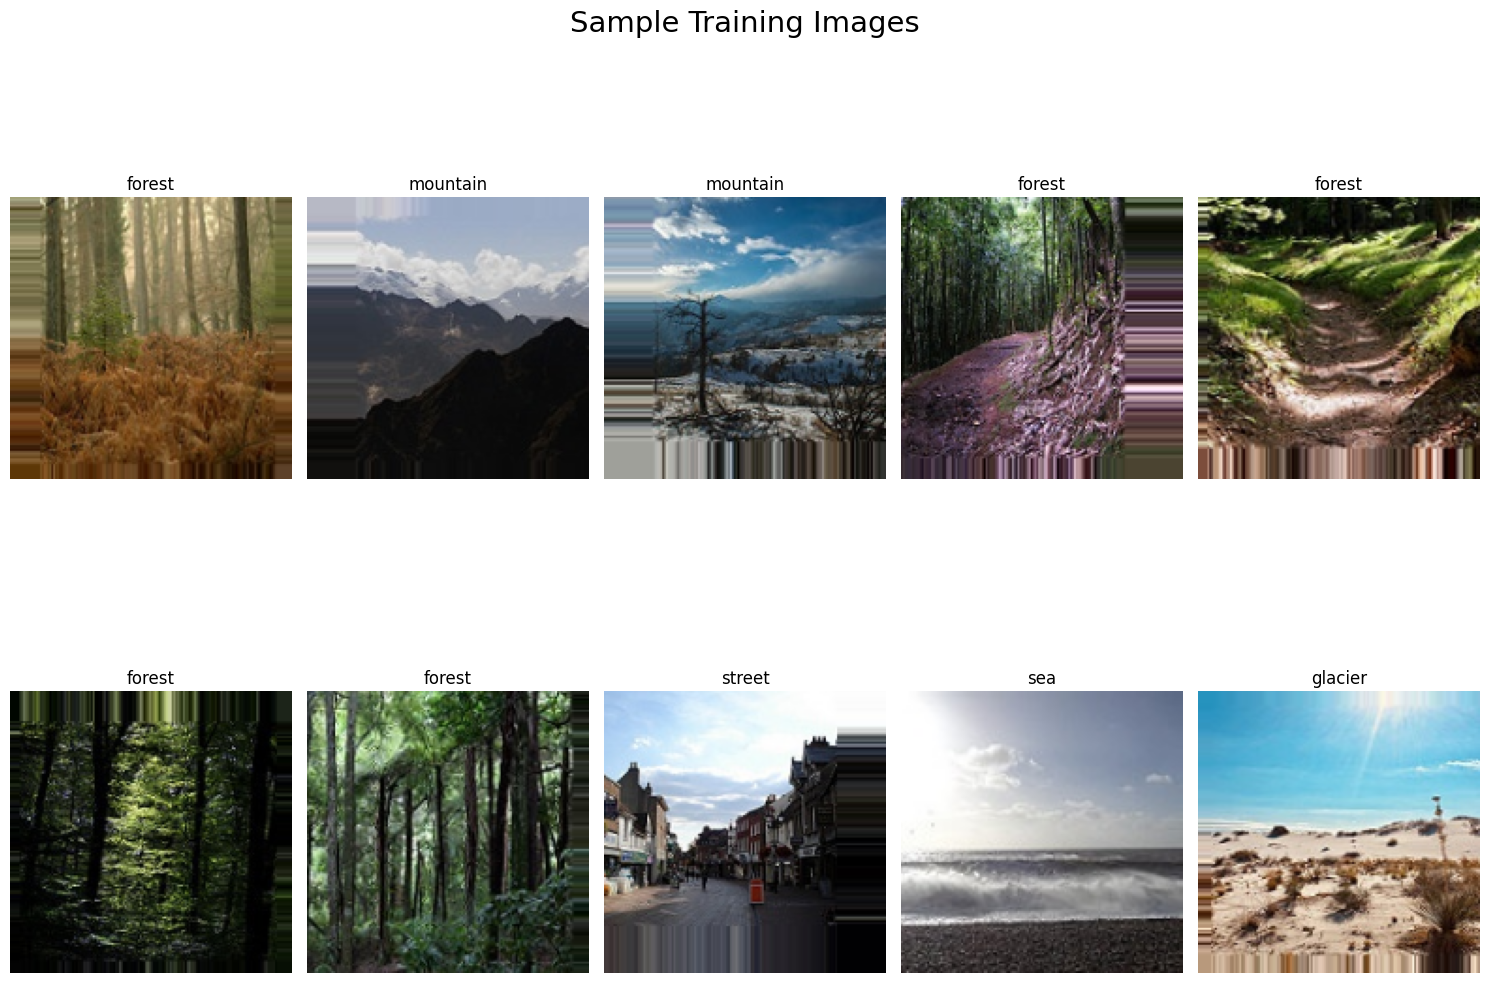

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# **4. Training a CNN Model**

**i. Create a CNN Model**

In [22]:
def create_model():       # Defining the model
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])

    return model

In [23]:
cnn_model = create_model()   # Creating the model

In [24]:
print(cnn_model.summary())   # Printing the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

**ii. Reduce Learning Rate on Plateau**

This is a callback object and is used to reduce the learning rate when a metric has stopped improving

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

**iii. Defining the Optimizer**

In [26]:
optimizer = Adam(learning_rate=0.001)

**iv. Compile the Model**

In [27]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

**v. Training the Model**

In [29]:
history = cnn_model.fit(train_generator, epochs=20, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/20
439/439 - 76s - loss: 2.0340 - accuracy: 0.5023 - val_loss: 1.6009 - val_accuracy: 0.4987 - lr: 0.0010 - 76s/epoch - 173ms/step
Epoch 2/20
439/439 - 76s - loss: 1.0839 - accuracy: 0.6053 - val_loss: 1.0149 - val_accuracy: 0.6273 - lr: 0.0010 - 76s/epoch - 173ms/step
Epoch 3/20
439/439 - 75s - loss: 0.9243 - accuracy: 0.6587 - val_loss: 1.1231 - val_accuracy: 0.6173 - lr: 0.0010 - 75s/epoch - 171ms/step
Epoch 4/20
439/439 - 76s - loss: 0.8410 - accuracy: 0.6912 - val_loss: 1.1261 - val_accuracy: 0.5660 - lr: 0.0010 - 76s/epoch - 173ms/step
Epoch 5/20
439/439 - 75s - loss: 0.8025 - accuracy: 0.7118 - val_loss: 1.1456 - val_accuracy: 0.6077 - lr: 0.0010 - 75s/epoch - 171ms/step
Epoch 6/20
439/439 - 75s - loss: 0.7536 - accuracy: 0.7294 - val_loss: 0.8351 - val_accuracy: 0.6807 - lr: 0.0010 - 75s/epoch - 171ms/step
Epoch 7/20
439/439 - 75s - loss: 0.7042 - accuracy: 0.7545 - val_loss: 0.6489 - val_accuracy: 0.7773 - lr: 0.0010 - 75s/epoch - 170ms/step
Epoch 8/20
439/439 - 74s - 

**vi. Plotting training and validation accuracy, loss and learning rate**

In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

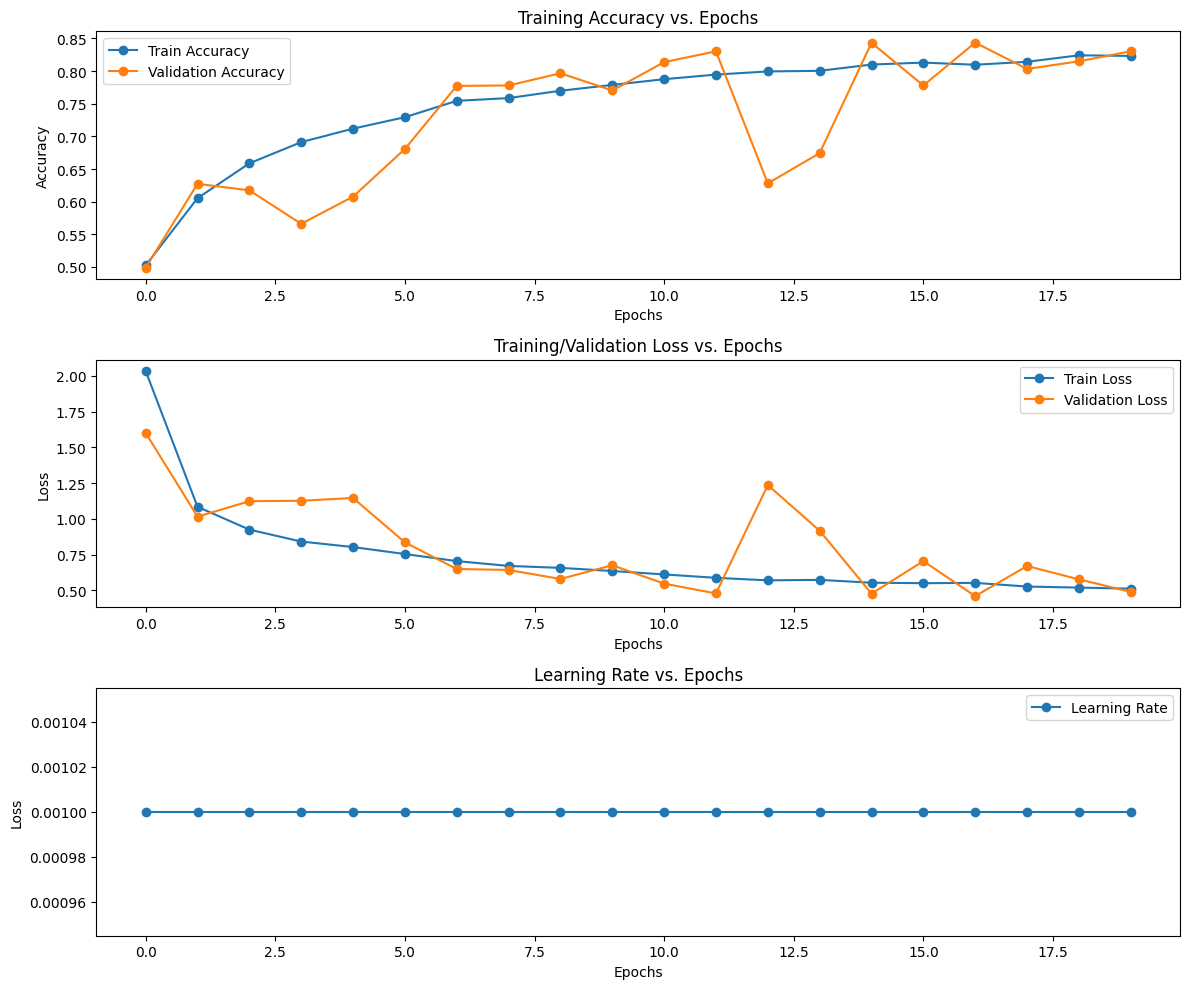

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# **5. Evaluation**

**Testing the Model on Test Set**

In [32]:
test_dataset = '/content/seg_test/seg_test/'

In [33]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


**Model Prediction on the Test Dataset**

In [34]:
predictions = cnn_model.predict(test_generator)

94/94 [==============================] - 3s 28ms/step


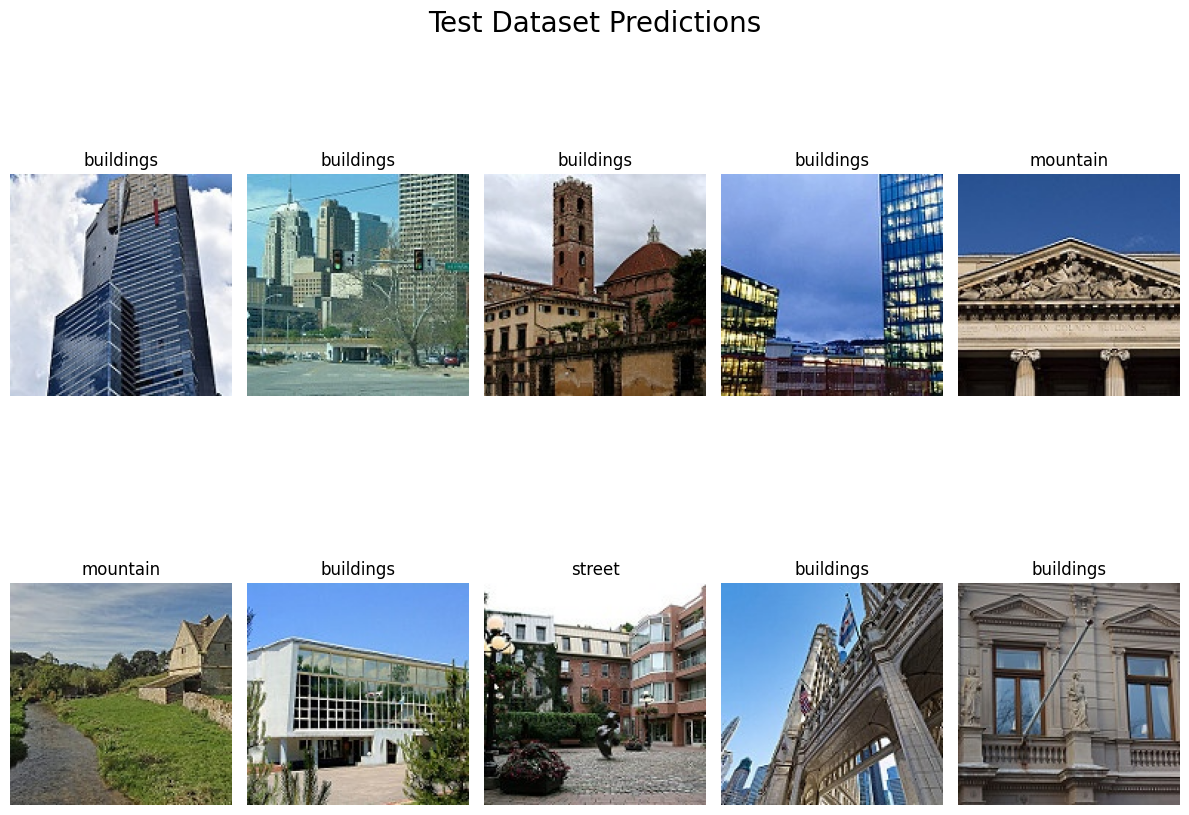

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))   # Plotting the test data predictions
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [36]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 3s 29ms/step - loss: 0.4885 - accuracy: 0.8303


In [37]:
print(f"Test Loss:     {test_loss}")      # Printing the test loss and test accuracy
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.48847082257270813
Test Accuracy: 0.8303333520889282


**Plotting the Classification Metrics**

In [38]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [39]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.92      0.75      0.83       437
      forest       0.90      0.99      0.94       474
     glacier       0.87      0.67      0.76       553
    mountain       0.66      0.91      0.77       525
         sea       0.88      0.82      0.85       510
      street       0.85      0.86      0.85       501

    accuracy                           0.83      3000
   macro avg       0.85      0.83      0.83      3000
weighted avg       0.85      0.83      0.83      3000



**Confusion Matrix**

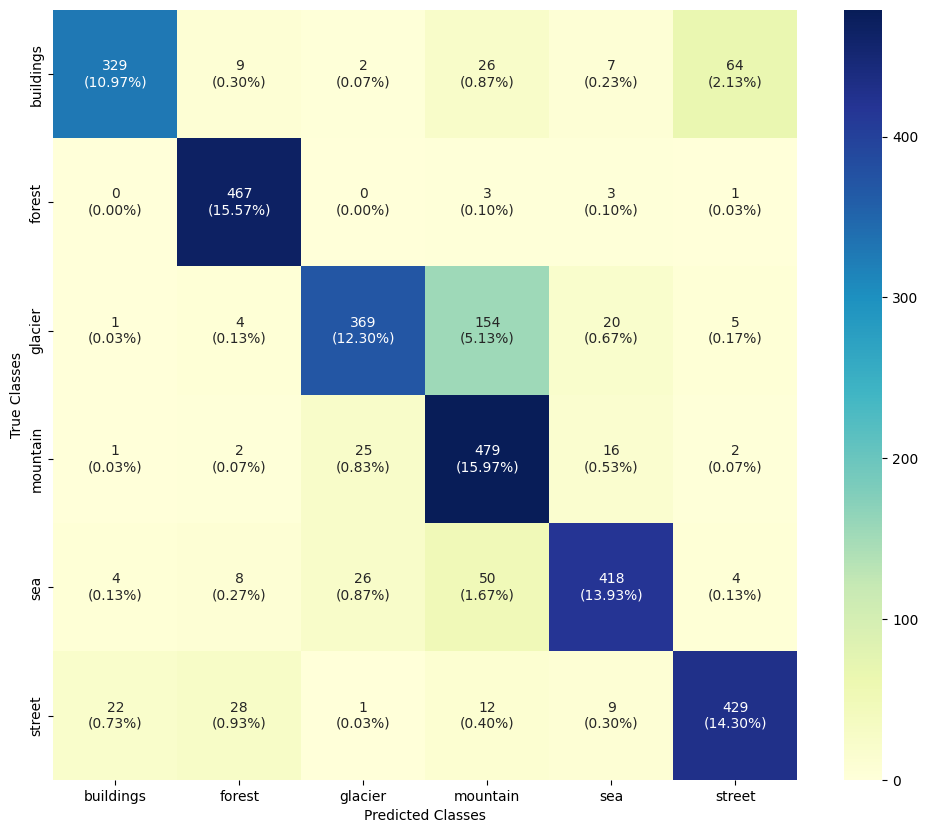

In [40]:
cf_mtx = confusion_matrix(y_true, y_pred)    # Plotting the confusion matrix

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# **6. Results Interpretation**

**Exploring misclassified images**

In [41]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [42]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

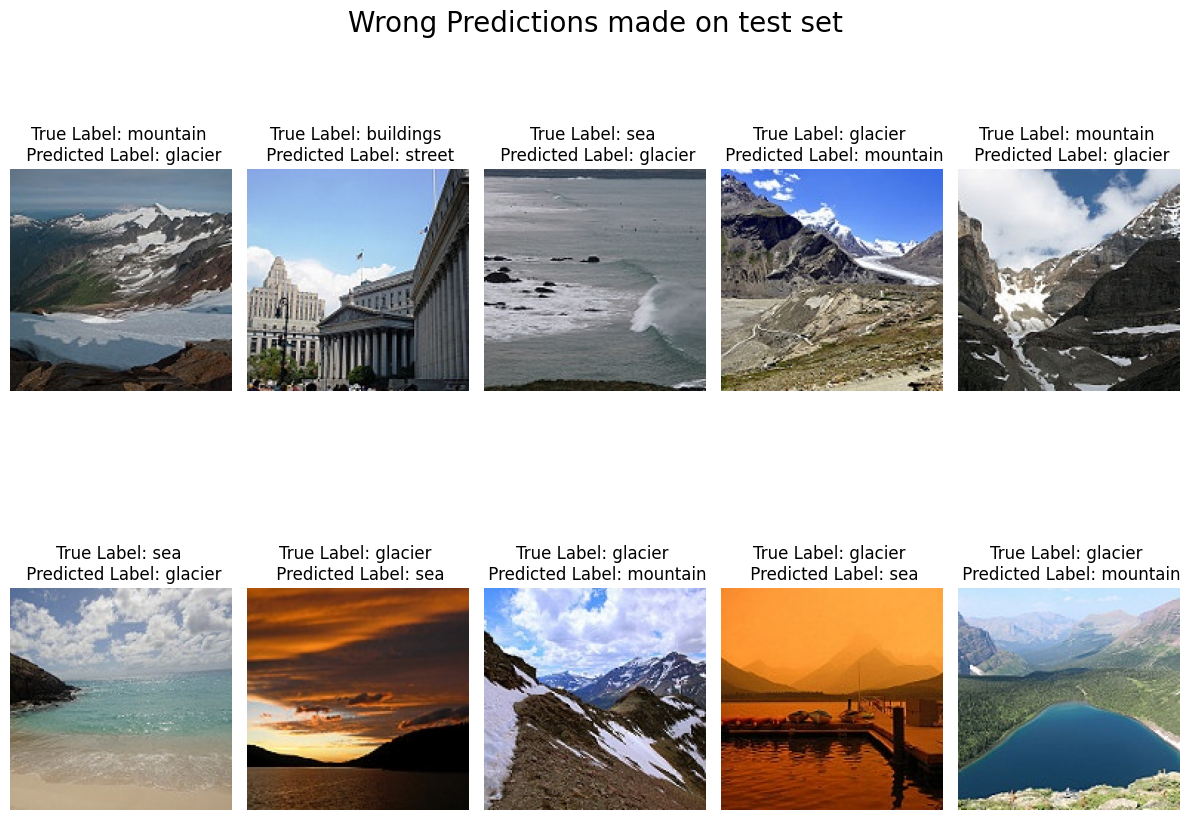

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

# **7. Conclusions and Recommendations**

**Findings:**

Test Loss: 0.488, indicating that, on average, the model's predictions are reasonably close to the actual values.

Test Accuracy: 0.830, suggesting that the model performs well, correctly classifying approximately 83% of the test data.

Precision, Recall, and F1-score: These metrics provide insights into the performance of the model for each class. Some classes like buildings and glacier have slightly lower precision and recall compared to others, indicating room for improvement.

**Recommendations:**

By fine-tuning the hyperparameters and incorporating regularization methods, we can optimize the model's performance and ensure it can effectively classify images while avoiding common pitfalls like overfitting.

Performance can also be increased by experimenting with ensemble methods, combining CNNs with other types of models like SVMs or decision trees, to leverage their complementary strengths in classification tasks.